In [12]:
# Analysis of all the unique triplets extracted
!pip install matplotlib

In [13]:
import os
import json
import pandas as pd
import numpy as np

In [14]:
def load_and_combine_json(base_path):
    # Initialize an empty list to collect all rows
    rows = []
    # Dictionary to hold disease names, their triplet count, and unique PubMed IDs
    disease_info = {}
    
    # Traverse the directory structure
    for disease in os.listdir(base_path):
        disease_folder = os.path.join(base_path, disease)
        if os.path.isdir(disease_folder):
            json_file_path = os.path.join(disease_folder, 'detailed_post_ontoGPT.json')
            if os.path.exists(json_file_path):
                # Open the JSON file and load the data into a dictionary
                with open(json_file_path, 'r') as file:
                    data = json.load(file)
                
                # Initialize or retrieve the dictionary entry for this disease
                if disease not in disease_info:
                    disease_info[disease] = {'triplet_count': 0, 'unique_pubmed_ids': set()}

                # Process the dictionary to extract triplets
                for entry in data['triplets']:
                    triplet = entry['triplet']
                    sources = entry['source']
                    # Extract PubMed IDs and count titles and abstracts
                    pubmed_ids = []
                    title_count = 0
                    abstract_count = 0
                    for pid, details in sources.items():
                        pubmed_ids.append(pid)
                        disease_info[disease]['unique_pubmed_ids'].add(pid)  # Store unique PubMed ID
                        if 'title' in details:
                            title_count += 1
                        if 'abstract' in details:
                            abstract_count += 1
                    
                    # Add disease name and source information to the triplet
                    triplet['disease'] = disease  # Add disease name to each triplet
                    triplet['count'] = entry['count']
                    triplet['source'] = pubmed_ids
                    triplet['no_of_titles'] = title_count
                    triplet['no_of_abstracts'] = abstract_count
                    
                    # Append the modified triplet to the list of rows
                    rows.append(triplet)

                    # Increment triplet count for this disease
                    disease_info[disease]['triplet_count'] += 1
    
    # Create DataFrame
    df = pd.DataFrame(rows)

    # # Print unique PubMed IDs count per disease and total triplet count per disease
    # for disease, info in disease_info.items():
    #     print(f"{disease}: {len(info['unique_pubmed_ids'])} unique PubMed IDs, {info['triplet_count']} triplets")

    # Optionally, return the dictionary of disease counts
    return df, disease_info

In [15]:

# Usage:
base_path = '/Users/niyone/Desktop/maxo/automaxo/dump/data_2.0'
df, disease_info = load_and_combine_json(base_path)


In [16]:
# Convert disease_info dictionary to DataFrame
disease_summary = pd.DataFrame({
    'Disease': list(disease_info.keys()),
    'Unique PubMed IDs': [len(info['unique_pubmed_ids']) for info in disease_info.values()],
    'Triplets': [info['triplet_count'] for info in disease_info.values()]
})

disease_summary

,Disease,Unique PubMed IDs,Triplets
0,loeys_dietz_syndrome,34,140
1,donnai-barrow_syndrome,3,20
2,camurati_engelmann,11,32
3,sickle_cell,974,3924
4,celiac_disease,1421,5617
5,canavan_disease,20,78
6,milroy_disease,2,5
7,chediak_higashi_syndrome,42,156
8,propionic_acidemia,40,171
9,hypochondroplasia,13,48


In [25]:
disease_summary.to_csv('disease_summary_2.0.tsv', sep='\t', index=False)

In [17]:
# Stept 2: Counting all the NANs

# Assuming df is your DataFrame
df = df.replace(['None'], np.nan)

# Replace empty lists with NaN in columns that can contain lists
for column in df.columns:
    df[column] = df[column].apply(lambda x: np.nan if x == [] else x)



In [18]:

# Define the function to calculate ontology metrics and return as a structured DataFrame
def calculate_ontology_metrics(df):
    # Total sum of titles and abstracts
    total_titles = df['no_of_titles'].sum()
    total_abstracts = df['no_of_abstracts'].sum()

    # Count of unique values in maxo, hpo, mondo
    unique_maxo = df['maxo'].nunique()
    unique_hpo = df['hpo'].nunique()
    unique_mondo = df['mondo'].nunique()

    # Count of total values in maxo, hpo, mondo
    total_maxo = df['maxo'].count()
    total_hpo = df['hpo'].count()
    total_mondo = df['mondo'].count()

    # Total count of non-grounded ontologies
    non_grounded_columns = [col for col in df.columns if 'non_grounded' in col]
    total_non_grounded = df[non_grounded_columns].notna().sum().sum()

    # Total count of potential ontologies identified
    potential_columns = [col for col in df.columns if 'potential' in col]
    total_potential = df[potential_columns].notna().sum().sum()

    # Count non-null values in non-grounded columns for maxo, hpo, mondo
    non_grounded_maxo_count = df['non_grounded_maxo'].notna().sum()
    non_grounded_hpo_count = df['non_grounded_hpo'].notna().sum()
    non_grounded_mondo_count = df['non_grounded_mondo'].notna().sum()

    # Count non-null values in potential columns for maxo, hpo, mondo
    potential_maxo_count = df['potential_maxo'].notna().sum()
    potential_hpo_count = df['potential_hpo'].notna().sum()
    potential_mondo_count = df['potential_mondo'].notna().sum()

    # Structuring data for visualization
    visualization_df = pd.DataFrame({
        "Labels": ['Unique Values', 'Total Values', 'Non-grounded Values', 'Potential Values'],
        "MAXO": [unique_maxo, total_maxo, non_grounded_maxo_count, potential_maxo_count],
        "HPO": [unique_hpo, total_hpo, non_grounded_hpo_count, potential_hpo_count],
        "MONDO": [unique_mondo, total_mondo, non_grounded_mondo_count, potential_mondo_count]
    })
    
    # Additional information on titles and abstracts, if needed
    extra_info = pd.DataFrame({
        "Metric": ["Total Titles", "Total Abstracts", "Total Non-Grounded Ontologies", "Total Potential Ontologies Identified"],
        "Count": [total_titles, total_abstracts, total_non_grounded, total_potential]
    })

    return visualization_df, extra_info

In [19]:

# Get the visualization DataFrame and additional information
visualization_df, extra_info = calculate_ontology_metrics(df)



In [20]:
visualization_df

,Labels,MAXO,HPO,MONDO
0,Unique Values,154,570,306
1,Total Values,1329,2967,8306
2,Non-grounded Values,11877,10239,4900
3,Potential Values,211,465,1291


In [21]:
extra_info

,Metric,Count
0,Total Titles,13558
1,Total Abstracts,13558
2,Total Non-Grounded Ontologies,27016
3,Total Potential Ontologies Identified,1967


### Results Visualization 

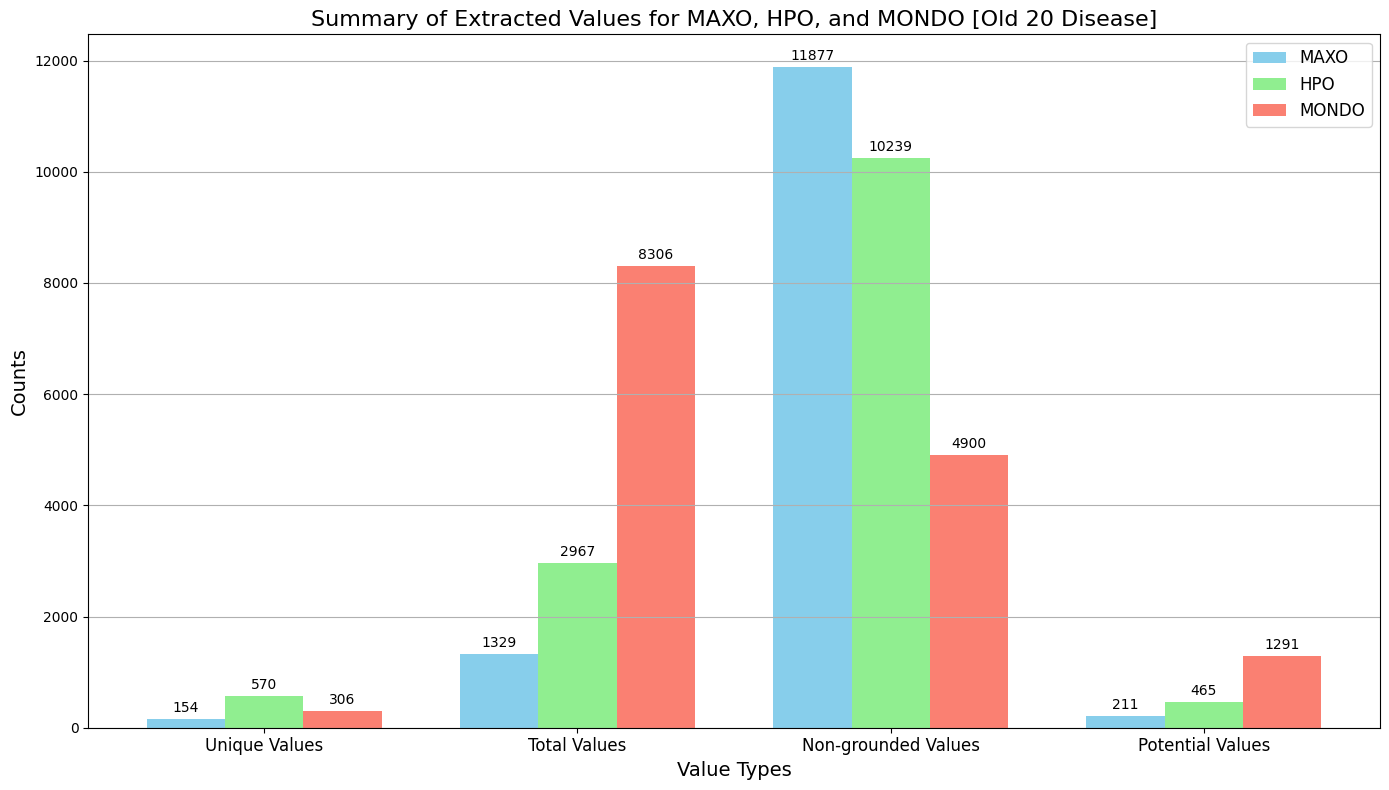

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the visualization_df
labels = visualization_df["Labels"].tolist()
maxo_values = visualization_df["MAXO"].tolist()
hpo_values = visualization_df["HPO"].tolist()
mondo_values = visualization_df["MONDO"].tolist()

# Bar width and positions
bar_width = 0.25
index = np.arange(len(labels))

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Creating bars with data labels
bars1 = ax.bar(index - bar_width, maxo_values, width=bar_width, label='MAXO', color='skyblue')
bars2 = ax.bar(index, hpo_values, width=bar_width, label='HPO', color='lightgreen')
bars3 = ax.bar(index + bar_width, mondo_values, width=bar_width, label='MONDO', color='salmon')

# Adding data labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Labels and title with increased font size
ax.set_xlabel('Value Types', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Summary of Extracted Values for MAXO, HPO, and MONDO [Old 20 Disease]', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=12)

# Grid for better readability
ax.yaxis.grid(True)

# Show plot
plt.tight_layout()
plt.show()
